In [27]:
import ipynb.fs.full.preProcessing as preProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
import seaborn as sns
import random

random.seed(1301266)

DECISION TREE MODEL:

Models: DecisionTreeRegressor, AdaBoostRegressor, RandomForestRegressor
```
DEPTH = 5
models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=100, max_depth=DEPTH)
}
```

Output: Offence rate at time t (t in 2015, 2016 due to limited communities data)
Assumptions: The communities.csv contains the data for 2014, 2015 (assume constant across the span of 2-3 years)
Features input: 
1. All features from communities (with 2 extra features for distance) at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
2. Only the top 20 features from communities with the highest NMI with offence rate at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
3. Use 1. with PCA on all communities feature (add the getPCA function)
4. Use 2. with PCA on all communities feature (add the getPCA function)

Evaluation: 50 folds validation, and take the median of RMSE/ MSE

Results: Noted below

Conclusion:
For both features set, only adaboost performs better than re-use the offence rate at (t-1).
Features set 2 results in a lower RMSE for adaboost and random forest.

MODEL SET 2:
Change the output to the offence rate difference (or ratio), since it's what we should focus on.

Null model (Take the mean of the train set): Outperform the tree, since the tree stop
considering the last offence rate as an important determinant
=> The last offence rate is the main performance booster for the tree

Result:
```
For features 1:
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 697426.027159028
RMSE of regressor : 835.120329157219
MSE of ada : 383065.340033446
RMSE of ada : 618.9163007242792
MSE of rf : 570348.7403033725
RMSE of rf : 755.1780375340123
RMSE of gradBoost: 616.91
```
For features 2:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 687015.5763979282
RMSE of regressor : 828.81992487444
MSE of ada : 373469.0699750013
RMSE of ada : 611.1193833613015
MSE of rf : 515237.70031876455
RMSE of rf : 717.6376753858078
RMSE of gradBoost: 612.20
```

For feature 3:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 842206.1779428092
RMSE of regressor : 917.6453167869898
MSE of ada : 406525.1654475378
RMSE of ada : 637.5728913206328
MSE of rf : 549143.0549892331
RMSE of rf : 741.0413152627207
MSE of gradBoost : 548636.7169944311
RMSE of gradBoost : 740.6272149355789
MSE of linear : 502306.9062239253
RMSE of linear : 708.7361326937958
```

For feature 4:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 687015.5763979295
RMSE of regressor : 828.8199248744409
MSE of ada : 345211.10021193756
RMSE of ada : 587.5434376201954
MSE of rf : 549651.2250462435
RMSE of rf : 741.3667120304194
MSE of gradBoost : 530883.5605228033
RMSE of gradBoost : 728.4829348116281
MSE of linear : 502379.2913162628
RMSE of linear : 708.7871938301332
```

In [28]:
# Preparing the frame for training model
offences = preProcess.cleanedOffences
offences = offences.drop(columns=["Offence Count"])

communities = preProcess.cleanedCommunities
communities["Distance from Melbourne"] = np.sqrt(communities["Location_x"]**2 + communities["Location_y"]**2)
communities["Direction from Melbourne"] = np.arctan(communities["Location_x"]/ communities["Location_y"])

housingPrices = preProcess.cleanedHousingPrice
egm = preProcess.cleanedEgm


In [29]:
from sklearn.preprocessing import OneHotEncoder

modelData = offences[(offences["Year"] == 2015) | (offences["Year"] == 2016)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    modelData.loc[idx, "Last Offence Rate"] = offences[(offences["LGA"] == row["LGA"]) 
                                            & (offences["Year"] == row["Year"] - 1)]["Rate per 100,000 population"].iloc[0]
    modelData.loc[idx, "Last Housing Price"] = housingPrices.loc[row["LGA"]][str(row["Year"] - 1)]
    modelData.loc[idx, "Last EGM"] = egm.loc[row["LGA"]][str(row["Year"] - 1)]


In [30]:
# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
renameCol = {}
for column in oneHotLGA.columns:
    renameCol[column] = "LGA" + str(column)
oneHotLGA = oneHotLGA.rename(columns=renameCol)
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

# One hot the region
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["Police Region"]).reshape(-1, 1))
# oneHotRegion = pd.DataFrame(oneHotEncoder
#                          .transform(np.array(modelData["Police Region"]).reshape(-1, 1))
#                          .toarray())
# renameCol = {}
# for column in oneHotRegion.columns:
#     renameCol[column] = "Region" + str(column)
# oneHotRegion = oneHotRegion.rename(columns=renameCol)
# modelData = modelData.join(oneHotRegion)
# modelData = modelData.drop(columns=["Police Region"])

X = modelData.drop(columns=["Rate per 100,000 population", "Year"])
y = modelData["Rate per 100,000 population"] 
# y = (modelData["Rate per 100,000 population"] - modelData["Last Offence Rate"])

modelData

,Year,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),ARIA+ (avg),Commercial (km^2),Industrial (km^2),Residential (km^2),...,LGA46,LGA47,LGA48,LGA49,LGA50,LGA51,LGA52,LGA53,LGA54,LGA55
0,2015,3705.064854,262.158611,12672.409204,2.009198,3.766950,2.820244,0.000036,0.000190,0.002115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015,11142.200000,79.549092,654.711013,0.223566,0.371822,0.298394,0.003524,0.018142,0.101532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015,7317.100000,20.289781,84.535123,0.000000,0.000000,0.000000,0.008991,0.021552,0.605656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015,8552.300000,106.172618,680.448934,1.334959,1.444840,1.384334,0.001338,0.001232,0.068730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,7883.000000,92.193741,4830.163654,0.723223,1.483585,1.084508,0.000219,0.000686,0.011533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2016,7314.794207,35.366070,937.879053,0.006308,0.058839,0.025918,0.003475,0.007859,0.129223,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
108,2016,8254.400000,215.072447,989.067744,0.673554,0.989005,0.794905,0.001546,0.011770,0.041257,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
109,2016,6775.100000,26.826134,517.402245,0.002064,0.009205,0.005557,0.003649,0.054778,0.159123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
110,2016,15075.200000,6.485248,20.822930,0.000000,0.000000,0.000000,0.127473,0.038506,0.484912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
from sklearn.decomposition import PCA
def getPCA(X_train, X_test, y_train = None):
    sklearn_pca = PCA(n_components=1)
    features_pca = sklearn_pca.fit(X_train)
    X_train["pca"] = features_pca.transform(X_train)
    X_test["pca"] = features_pca.transform(X_test)
    return X_train, X_test

In [32]:
def getSplitAttributes(tree_rules: str):
    # Parsing the split attributes
    splitAtts = []
    AttRegex = r".*\|--- ([^<>=]*) [<>=].*"

    for line in tree_rules.split("\n"):
        # print(line)
        matchObj = re.match(AttRegex, line)
        if matchObj:
            att = matchObj.group(1)
            splitAtts.append(att)
            # print(att)
    return splitAtts

In [33]:
class NullModel():
    def __init__(self) -> None:
        self.trainMean = 0

    def fit(self, X_train, y_train):
        self.trainMean = np.mean(y_train)
        return self
    
    def predict(self, X_test):
        return [self.trainMean] * len(X_test)


In [34]:
from sklearn.metrics import mean_squared_error

def trainTestPipeline(X_train, X_test, y_train, y_test, featureEngineerFunc, models, printable = True):
    if featureEngineerFunc:
        X_train, X_test = featureEngineerFunc(X_train, X_test, y_train)    
    predicts = {}
    mses = {}

    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    # Get the default mse using last rate
    modelTest = modelData.loc[X_test.index]
    mse_null_2 = mean_squared_error(modelTest["Rate per 100,000 population"], modelTest["Last Offence Rate"])
    mses["null2"] = mse_null_2


    for name in models:
        mses[name] = (mean_squared_error(predicts[name], y_test))
        
    if printable:
        for key in mses:
            print("RMSE of ", key, ":", np.sqrt(mses[key]))
    return X_train, X_test, mses, predicts

In [35]:
# K-fold, since the above is pretty random
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree, export_text

def KFoldPipeline(X, y,
                  featureEngineerFunc, models, 
                  n = 10, printable = True, 
                  X_val = None, y_val = None):
    # Change to 50 for actual evaluation

    nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
    msesTotal = {}

    # relavantAttributes = []
    relevantAttributes = {}

    for train_idx, test_idx in nf_CV.split(X):
        # train-test split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if X_val is not None:
            X_train = pd.concat([X_train, X_val])
            y_train = pd.concat([y_train, y_val])

        X_train, X_test, mses, predicts = trainTestPipeline(X_train, X_test, y_train, y_test,
                                           featureEngineerFunc, models, 
                                           printable=False)

        for key in mses:
            if key not in msesTotal:
                msesTotal[key] = []
            msesTotal[key].append(mses[key])

        # Get the summary of all attributes
        # if "regressor" in models:
        #     tree_rules = export_text(models["regressor"], feature_names=list(X_train))
        #     relavantAttributes.extend(getSplitAttributes(tree_rules))

        if "ada" in models:
            for i in range(len(models["ada"].estimators_)):
                model = models["ada"].estimators_[i]
                weight = models["ada"].estimator_weights_[i]
                tree_rules = export_text(model, feature_names=list(X_train))
                allAtts = getSplitAttributes(tree_rules)
                for att in allAtts:
                    if att not in relevantAttributes:
                        relevantAttributes[att] = 0
                    relevantAttributes[att] += weight

    if printable:
        # Print the RMSE for each model
        for key in mses:
            print("MSE of", key, ":", np.median(msesTotal[key]))
            print("RMSE of", key, ":", np.median(np.sqrt(msesTotal[key])))



        print("Used attributes for regressor tree: ")
        print(relevantAttributes)
        splittingAtts = list(relevantAttributes.items())
        splittingAtts.sort(key = lambda x: -x[1])

        plt.figure()
        plt.title("Top 7 splitting attributes")
        plt.barh([pair[0] for pair in splittingAtts[:7][::-1]], 
                 [pair[1] for pair in splittingAtts[:7][::-1]])
        plt.show()



        for name in mses:
            plt.figure()
            fig, axs = plt.subplots(1, 2)
            fig.suptitle("RMSE of " + name)
            axs[0].hist(np.sqrt(msesTotal[name]))
            axs[1].boxplot(np.sqrt(msesTotal[name]))
            plt.show()
        

FEATURES 3 (and 1): All features + PCA

Remove PCA to get the feature 1 set

In [36]:
# Define models here
# Models: https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/
# AdaBoost model (TODO: Recheck source): Train an initial tree with uniform weight for all points.
# Then, for subsequent iterations, change the weights so more weights are given for
# the points with errors.
# Then, random selection based on the normalized probability weights for the data points
# to construct a new datasets => Train a new tree on top of it 
# At the end, with 300 iterations, around 300 decision trees are built and used for regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

RMSE of  null2 : 840.6042623633698
RMSE of  regressor : 1740.2087222710024
RMSE of  ada : 982.1653876257125
RMSE of  rf : 1130.3676808533592
RMSE of  gradBoost : 1554.7951979009974
RMSE of  linear : 2997.952313314394
RMSE of  null : 2719.842874333697


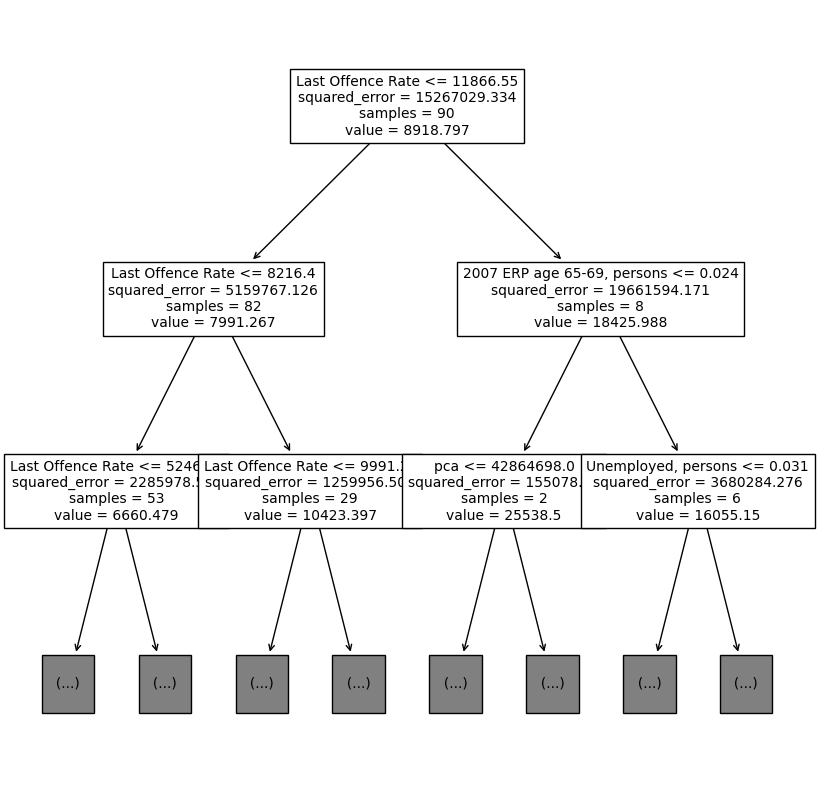

|--- Last Offence Rate <= 11866.55
|   |--- Last Offence Rate <= 8216.40
|   |   |--- Last Offence Rate <= 5246.75
|   |   |   |--- Last Offence Rate <= 4071.45
|   |   |   |   |--- Direction from Melbourne <= 0.20
|   |   |   |   |   |--- value: [4356.70]
|   |   |   |   |--- Direction from Melbourne >  0.20
|   |   |   |   |   |--- value: [3571.90]
|   |   |   |--- Last Offence Rate >  4071.45
|   |   |   |   |--- Last Offence Rate <= 4357.45
|   |   |   |   |   |--- value: [4617.20]
|   |   |   |   |--- Last Offence Rate >  4357.45
|   |   |   |   |   |--- value: [5180.71]
|   |   |--- Last Offence Rate >  5246.75
|   |   |   |--- Last Offence Rate <= 6990.96
|   |   |   |   |--- Last Offence Rate <= 5932.78
|   |   |   |   |   |--- value: [6258.61]
|   |   |   |   |--- Last Offence Rate >  5932.78
|   |   |   |   |   |--- value: [7286.73]
|   |   |   |--- Last Offence Rate >  6990.96
|   |   |   |   |--- IRSD (avg) <= 1002.34
|   |   |   |   |   |--- value: [8229.73]
|   |   |   | 

In [43]:
# Use hold out for now, to investigate the tree closely
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

DEPTH = 5

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=300, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=300, max_depth=DEPTH),
    "gradBoost": GradientBoostingRegressor(n_estimators = 500,
        max_depth = DEPTH,
        min_samples_split = 3,
        learning_rate = 0.01,
        loss = "squared_error"),
    "linear": LinearRegression(),
    "null": NullModel()
}

# 19 random state yields some odd precision, likely due to how the split is constructed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

featureEngineerFunc = getPCA
X_train, X_test, mses, predicts = trainTestPipeline(X_train, X_test, y_train, y_test, featureEngineerFunc, models)

# Reserve the X_test, y_test here as validation set
# Use this block for hyper-param tuning, thus can't use the validation set 
# for testing. Re-use it for training.
X_val = X_test
y_val = y_test

X = X_train
y = y_train

# Check the decision tree regressor
fig, axe = plt.subplots(figsize=(10,10))
plot_tree(models["regressor"], 
          feature_names=X_train.columns,
          ax=axe, 
          fontsize=10,
          max_depth=2)
plt.show()

# Use text
tree_rules = export_text(models["regressor"], feature_names=list(X_train))
print(tree_rules)

print("Concise list of attributes")
print(pd.Series(getSplitAttributes(tree_rules)).value_counts())





C:\Users\DELL\AppData\Local\Temp\ipykernel_9512\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9512\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9512\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

MSE of null2 : 428205.588030917
RMSE of null2 : 654.3662763885982
MSE of regressor : 504391.58043673704
RMSE of regressor : 710.2036653734174
MSE of ada : 344256.6250423614
RMSE of ada : 586.7174244687479
MSE of rf : 403660.26594356494
RMSE of rf : 635.3390753069095
MSE of gradBoost : 434397.6679533427
RMSE of gradBoost : 658.7658105539615
MSE of linear : 366493.96715954586
RMSE of linear : 605.0362102294824
MSE of null : 6793443.447732713
RMSE of null : 2606.3806385903026
Used attributes for regressor tree: 
{'Last Offence Rate': 454084.57602008496, 'Population': 4928.489099464556, 'Last Housing Price': 84605.31231223134, '2007 ERP age 25-44, persons': 4769.0307422087235, 'Holds degree or higher, persons': 9767.193079626577, 'Born in non-English speaking country, persons': 4258.72064169664, '% residing near PT': 4306.240472740024, 'Rural (km^2)': 3731.4242542094244, 'Male-headed lone parent families': 10685.003241631119, '2007 ERP age 45-64, persons': 7405.774097615993, '2012 ERP age 

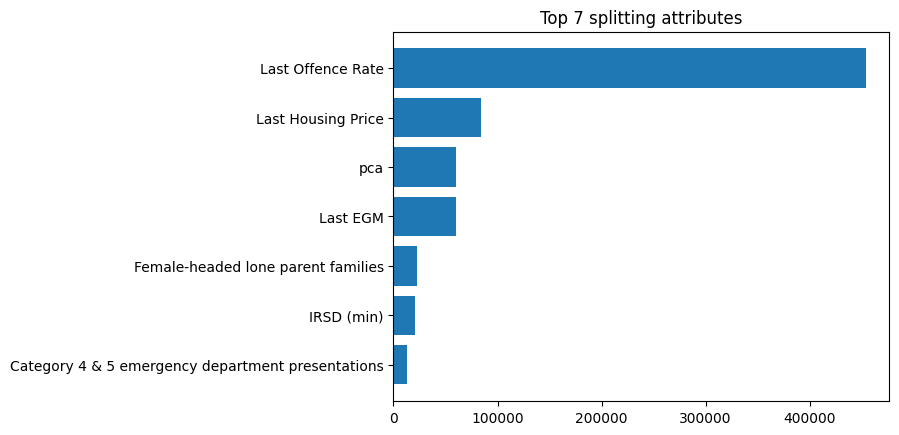

<Figure size 640x480 with 0 Axes>

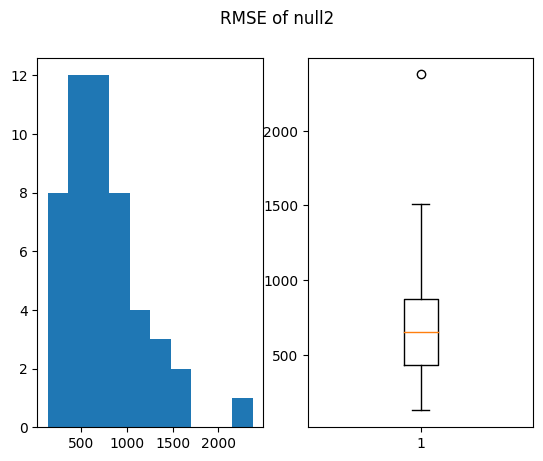

<Figure size 640x480 with 0 Axes>

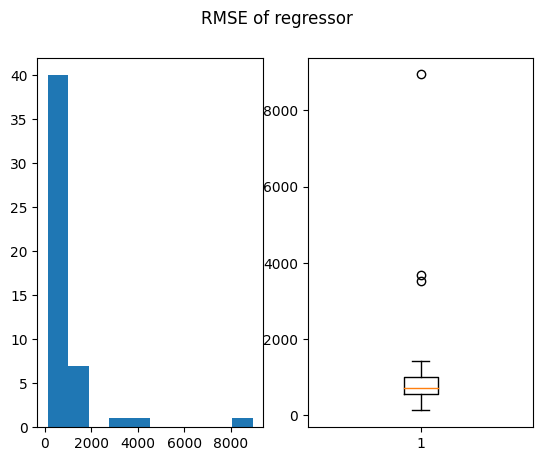

<Figure size 640x480 with 0 Axes>

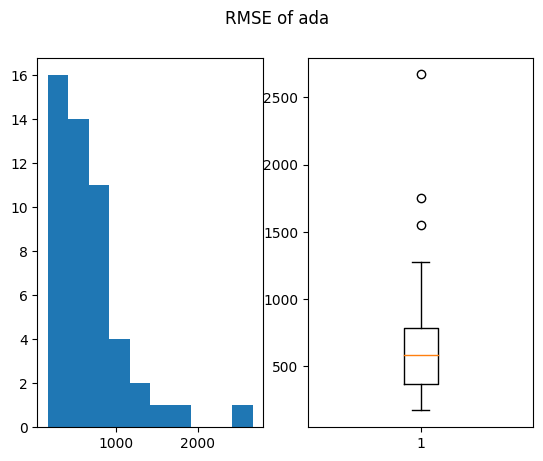

<Figure size 640x480 with 0 Axes>

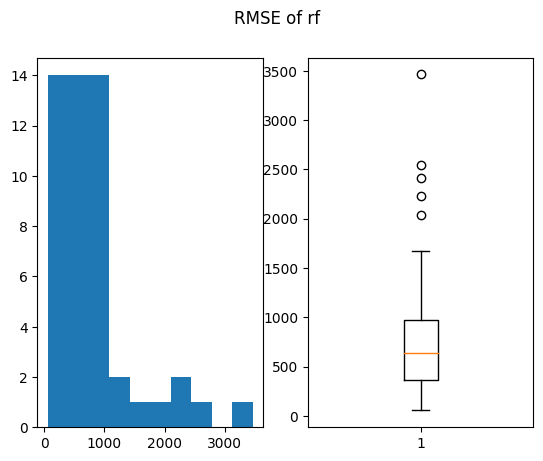

<Figure size 640x480 with 0 Axes>

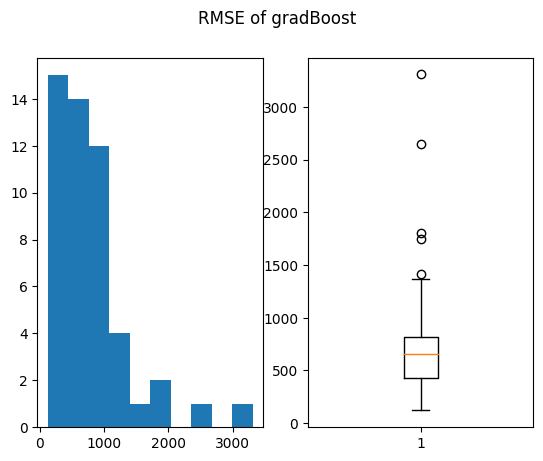

<Figure size 640x480 with 0 Axes>

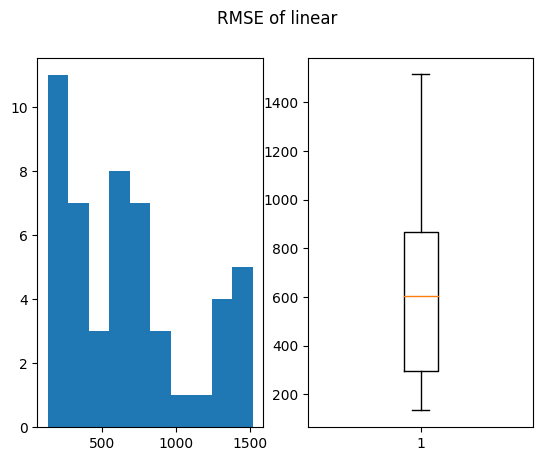

<Figure size 640x480 with 0 Axes>

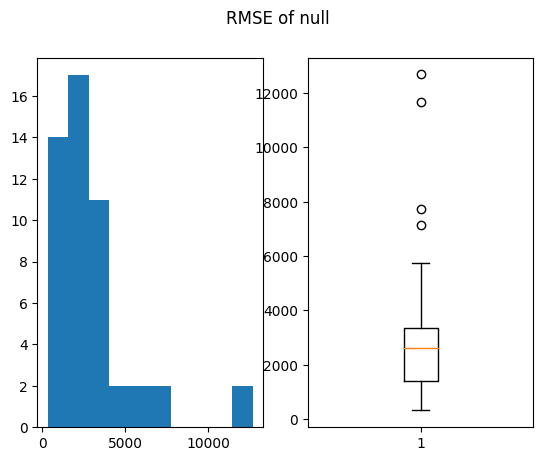

In [38]:
# FEATURE 1:
DEPTH = 5

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=300, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=300, max_depth=DEPTH),
    "gradBoost": GradientBoostingRegressor(n_estimators = 500,
        max_depth = DEPTH,
        min_samples_split = 3,
        learning_rate = 0.01,
        loss = "squared_error"),
    "linear": LinearRegression(),
    "null": NullModel()
}

featureEngineerFunc = None
featureEngineerFunc = getPCA
KFoldPipeline(X, y, featureEngineerFunc, models, 50, True, X_val=X_val, y_val=y_val)

FEATURE 4 (and 2): Pick the top 20 highest NMI score features only + PCA

Remove the getPCA to achieve the feature 2 (no PCA).

In [39]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Since most attribute uses the default discretiser, 
# this function will help with the NMI calculation
def getNMI(att1: np.array, att2: np.array, n_bins=5):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    # Avoid the removal of bin by normalizing the data
    norm_att1 = (att1 - att1.min())/ (att1.max() - att1.min()) * 100
    norm_att2 = (att2 - att2.min())/ (att2.max() - att2.min()) * 100

    discrete_att1 = discretizer.fit_transform(norm_att1.reshape(-1, 1)).astype(int)
    discrete_att2 = discretizer.fit_transform(norm_att2.reshape(-1, 1)).astype(int)
    return normalized_mutual_info_score(discrete_att1.flatten(), discrete_att2.flatten())

def getTopNMICommunities(X_train, y_train):
    allScores = []
    for column in communities.columns:
        if column not in X_train.columns:
            continue
        score = getNMI(np.array(X_train[column]), np.array(y_train))
        allScores.append((column, score))
    allScores.sort(key=lambda x: -x[1])
    return [col[0] for col in allScores][:20]

def featureEngineerFunc2(X_train, X_test, y_train):
    # X_train, X_test = getPCA(X_train, X_test)

    top20Communities = getTopNMICommunities(X_train, y_train)
    dropCol = []
    for column in communities.columns:
        if column in X.columns and column not in top20Communities:
            dropCol.append(column)

    X_train = X_train.drop(columns=dropCol)
    X_test = X_test.drop(columns=dropCol)
    return X_train, X_test

d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose widt

MSE of null2 : 428205.588030917
RMSE of null2 : 654.3662763885982
MSE of regressor : 566512.2259069427
RMSE of regressor : 752.6651657152333
MSE of ada : 304873.74026010605
RMSE of ada : 551.4112516830003
MSE of rf : 426254.38048660086
RMSE of rf : 652.7677610669534
MSE of gradBoost : 425970.5844983442
RMSE of gradBoost : 652.6399472040353
MSE of linear : 367236.29985443014
RMSE of linear : 605.6288930045035
MSE of null : 6793443.447732713
RMSE of null : 2606.3806385903026
Used attributes for regressor tree: 
{'Last Offence Rate': 477567.0125668112, 'Requires assistance with core activities, persons': 22416.525615140054, 'LGA30': 1524.3017619933626, 'pca': 74655.14522893274, 'Holds degree or higher, persons': 26954.03099381632, 'Public Housing Dwellings': 23638.049756529937, 'Dwellings with no motor vehicle': 19193.932744301605, 'Male-headed lone parent families': 28734.371589620652, 'Kinder and/or Childcare': 23129.323339627932, 'TAFE students': 21734.203723727514, 'Last Housing Price

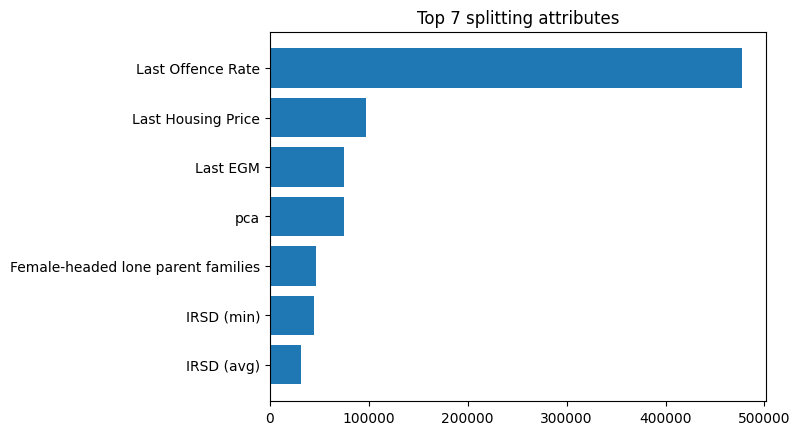

<Figure size 640x480 with 0 Axes>

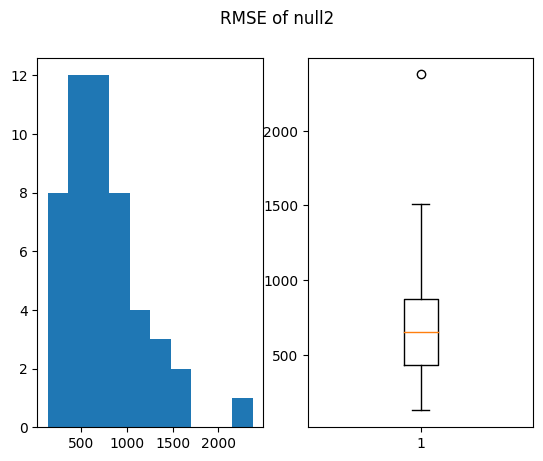

<Figure size 640x480 with 0 Axes>

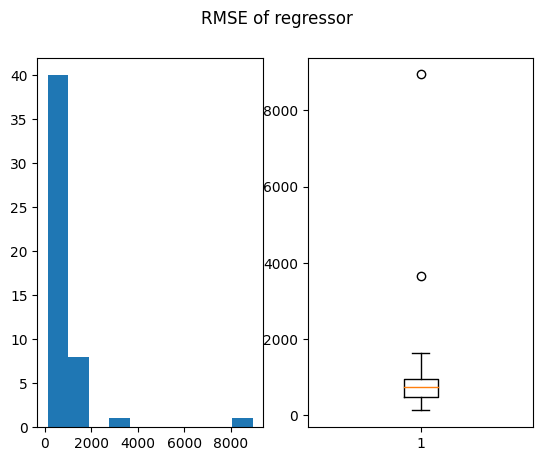

<Figure size 640x480 with 0 Axes>

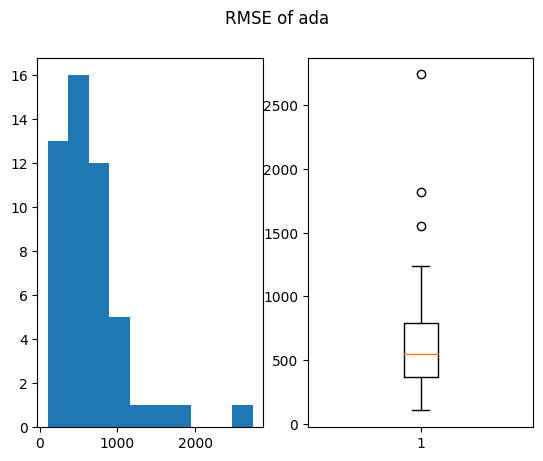

<Figure size 640x480 with 0 Axes>

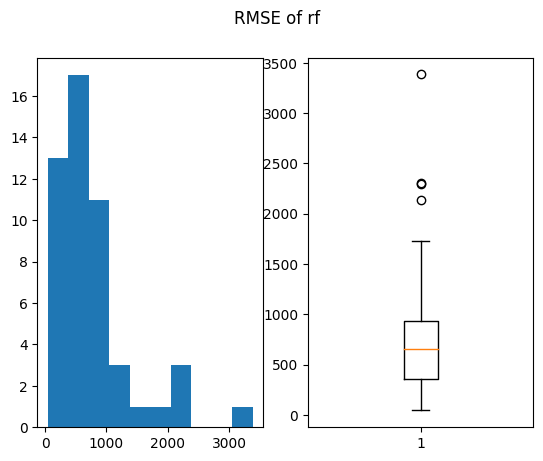

<Figure size 640x480 with 0 Axes>

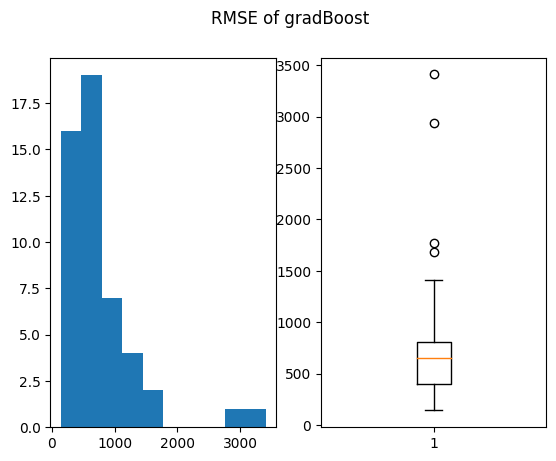

<Figure size 640x480 with 0 Axes>

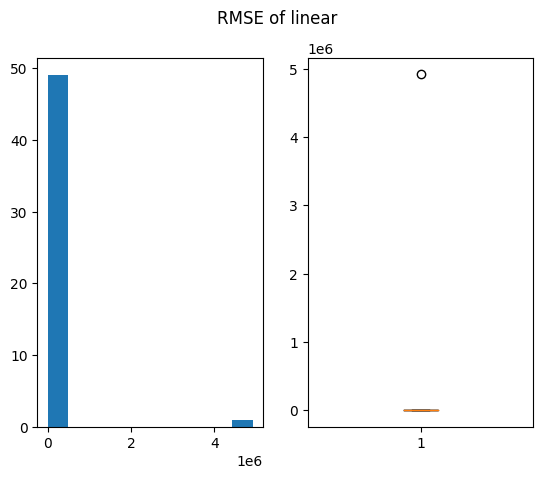

<Figure size 640x480 with 0 Axes>

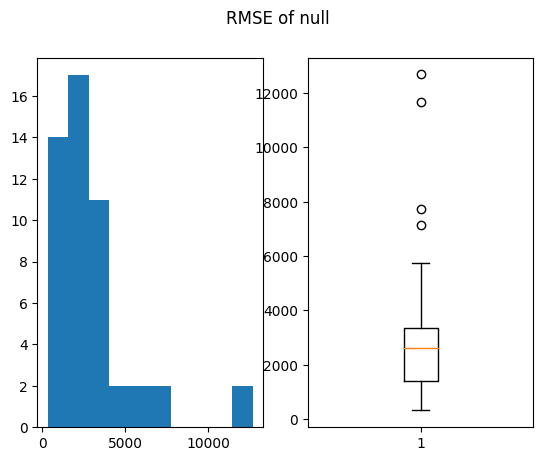

In [40]:
DEPTH = 5

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=300, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=300, max_depth=DEPTH),
    "gradBoost": GradientBoostingRegressor(n_estimators = 500,
        max_depth = DEPTH,
        min_samples_split = 3,
        learning_rate = 0.01,
        loss = "squared_error"),
    "linear": LinearRegression(),
    "null": NullModel()
}

KFoldPipeline(X, y, featureEngineerFunc2, models, 50, True, X_val=X_val, y_val=y_val)

In [41]:
# Try restricting to top 20 of highest correlation coeff for Linear model
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

def getTopCorrCoeffCommunities(X_train, y_train):
    allScores = []
    for column in communities.columns:
        if column not in X_train.columns:
            continue
        score = abs(np.corrcoef(np.array(X_train[column]), np.array(y_train))[0][1])
        allScores.append((column, score))
    allScores.sort(key=lambda x: -x[1])
    return [col[0] for col in allScores][:20]

def featureEngineerLinearFunc2(X_train, X_test, y_train):
    # X_train, X_test = getPCA(X_train, X_test)

    top20Communities = getTopCorrCoeffCommunities(X_train, y_train)
    dropCol = []
    for column in communities.columns:
        if column in X.columns and column not in top20Communities:
            dropCol.append(column)

    X_train = X_train.drop(columns=dropCol)
    X_test = X_test.drop(columns=dropCol)
    return X_train, X_test

MSE of null2 : 428205.588030917
RMSE of null2 : 654.3662763885982
MSE of linear : 366494.0086036296
RMSE of linear : 605.0362424446548
MSE of null : 6793443.447732713
RMSE of null : 2606.3806385903026
Used attributes for regressor tree: 
{}


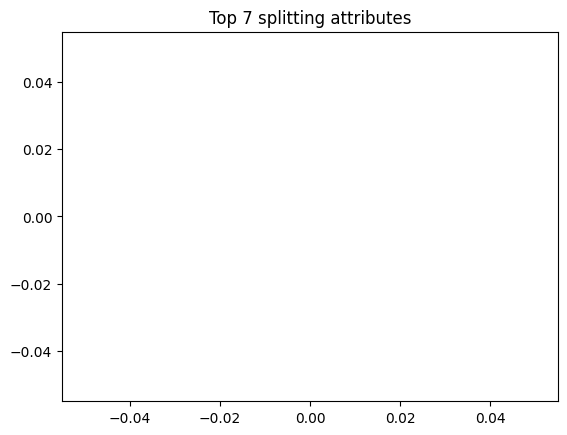

<Figure size 640x480 with 0 Axes>

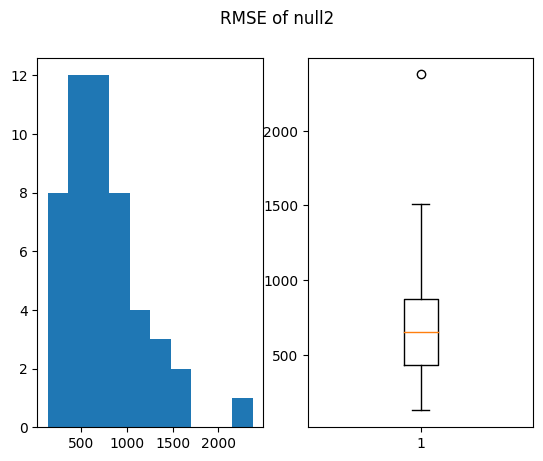

<Figure size 640x480 with 0 Axes>

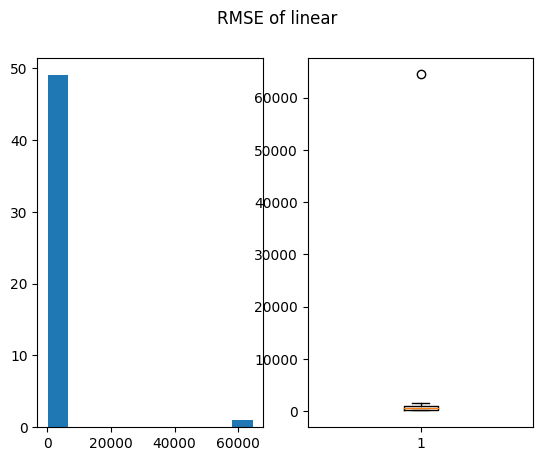

<Figure size 640x480 with 0 Axes>

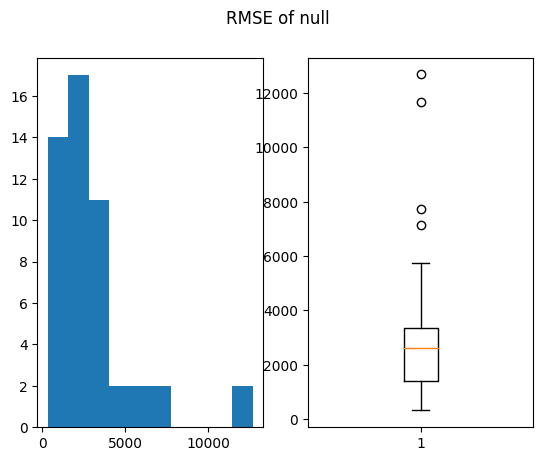

In [42]:
models = {
    "linear": LinearRegression(),
    "null": NullModel()
}

KFoldPipeline(X, y, featureEngineerLinearFunc2, models, 50, True, X_val=X_val, y_val=y_val)